# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import itertools

## Configuration Class
A simple class to manage configuration

In [2]:
class Config():
#     training_dir = "./dataset/db_periocular/train"
#     train_batch_size = 64
#     train_number_epochs = 300

    testing_dir = "./dataset/db_cropped_face/val"

## Neural Net Definition
We will use a standard convolutional neural network

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            # Conv2d: 입력채널 수, 출력채널 수, 필터크기, 패딩
            nn.Conv2d(1, 64, kernel_size=10, padding=0), # 105*105*1 → 96*96*64
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d((2,2), stride=(2, 2)), # 96*96*64 → 48*48*64
            
            nn.Conv2d(64, 128, kernel_size=7, padding=0), # 48*48*64 → 42*42*128
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            
            nn.MaxPool2d((2,2), stride=(2, 2)), # 42*42*128 → 21*21*128

            nn.Conv2d(128, 128, kernel_size=4, padding=0), # 21*21*128 → 18*18*128
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            
            nn.MaxPool2d((2,2), stride=(2, 2)), # 18*18*128 → 9*9*128
            
            nn.Conv2d(128, 256, kernel_size=4, padding=0), # 9*9*128 → 6*6*256 (9*9*256)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(6*6*256, 4096), # 6*6*256=9216 → 4096
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096), # 1줄 → BatchNorm1d
            
            nn.Linear(4096, 1000), # 4096 → 1000
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1000), # 1줄 → BatchNorm1d
            
            nn.Linear(1000, 100)) # 1000 → 100


    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# 학습된 파라미터(weight) 불러오기

In [4]:
load_netname = './new_weights/weights_face/0805_Adam_1e-4/epoch-290 loss-0.028625909239053726.pkl'

net = torch.load(load_netname) # pkl파일로 학습된 모델을 불러오기

In [5]:
# print(list(net.parameters())) # 파라미터 출력

## Testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

testing 추가사항 : dataloader를 새로 정의해서 pair를 랜덤이 아닌 순서대로 불러옴

In [6]:
def matching(img1,img2,network): #img pair를 입력으로 받아서 유클라디안 거리 계산
    transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()])
    
    img1 = Image.open(img1)
    img2 = Image.open(img2)
    
    img1_ = img1.convert("L")
    img2_ = img2.convert("L") #grayscale로 변환
    
    img1 = transform(img1_)
    img2 = transform(img2_)
    #img1 = torch.squeeze(img1)
    #print (img1.shape)
    img1 = torch.unsqueeze(img1, 0)
    img2 = torch.unsqueeze(img2,0)

    
    output1, output2 = network(Variable(img1).cuda(), Variable(img2).cuda()) # Tensor
    
    output_vec1 = np.array(output1.cpu().detach().numpy())
    output_vec2 = np.array(output2.cpu().detach().numpy())
    
#     print(output_vec1) # np.array
#     print(output_vec2)
    
    euclidean_distance = np.sqrt(np.sum(np.square(np.subtract(output_vec1, output_vec2))))
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     euclidean_distance = F.pairwise_distance(output_vec1, output_vec2)
    return euclidean_distance

In [7]:
import os
import itertools
import time

start = time.time()
gn=0 #genuine matching 횟수
In=0 #imposter matching 횟수

# gns=0 #genuine matching 성공횟수
# gnf=0
# ins=0 #imposter matching 성공횟수
# inf=0



# arr = ['A', 'B', 'C']
# nCr = itertools.combinations(arr, 2)
# print(list(nCr))

#Genuine matching data loader
path=Config.testing_dir
folder_list= os.listdir(path) 
file_list=[]

for folder_num in range(len(folder_list)):
    print ("folder: %s" %folder_list[folder_num])
    dirs = path + '/' + folder_list[folder_num]
    for file in os.listdir(dirs): #폴더 안 파일
        file_list.append((dirs + '/' + file,folder_list[folder_num])) #폴더안 (파일 경로,폴더 이름) 튜플 리스트에 저장
        
#print (file_list)                    
combination = list(itertools.combinations(file_list,2)) #한 폴더 안 Genuine matching조합 경우의수
print (len(combination)) # 첫번째 genuine matching 이미지 pair


net.eval() # 성능 테스트를 할 때 네트워크 모델을 평가용으로 사용(학습X)

distances_list = [] # squared L2 distance between pairs
identical_list = [] # 1 if same identity, 0 otherwise

In_bal = 0

for c in combination:
    #print (c[0][1],c[1][1])
    if (c[0][1]==c[1][1]) :  #genuine matching
        distance = matching(c[0][0],c[1][0],net) #float
        
        distances_list.append(distance)
        identical_list.append(1)
        
        gn+=1
        if (gn % 100 == 1):
                print("%dth genuine matching..." % gn)

#         if (distance<0.5):
#             gns+=1
#         else:
#             gnf+=1
        
    else : #imposter matching
        In_bal = In_bal + 1
        if (In_bal % 140 == 1): # validation, test: 140
            distance = matching(c[0][0],c[1][0],net)
            
            distances_list.append(distance)
            identical_list.append(0)
            
            In+=1
            if (In % 100 == 1):
                print("%dth imposter matching..." % In)

#             if(distance>0.5):
#                 ins+=1
#             else:
#                 inf+=1
    

print ("\ngenuine matching 횟수: %d" %gn)
print ("imposter matching 횟수: %d" %In)

end = time.time()

print("-------------------------\n")
print("Total Matching Time: %f s" %(end - start))

# print ("genuine matching 횟수", gn)
# print ("imposter matching 횟수", In)
# print ("genuine matching 성공횟수", gns)  
# print ("imposter matching 성공횟수", ins)
# print ("genuine matching 성공률(TP)", float(gns)/gn)
# print ("imposter matching 성공률(TN)", float(ins)/In)
# print ("genuine matching FP", inf/In)
# print ("genuine matching FN", gnf/gn)
# print (float(gns)/gn + gnf/gn)

folder: 0923
folder: 0925
folder: 0927
folder: 0929
folder: 0931
folder: 0933
folder: 0935
folder: 0937
folder: 0939
folder: 0941
folder: 0943
folder: 0945
folder: 0947
folder: 0949
folder: 0951
folder: 0953
folder: 0955
folder: 0957
folder: 0959
folder: 0961
folder: 0963
folder: 0965
folder: 0967
folder: 0969
folder: 0971
folder: 0973
folder: 0975
folder: 0977
folder: 0979
folder: 0981
folder: 0983
folder: 0985
folder: 0987
folder: 0989
folder: 0991
folder: 0993
folder: 0995
folder: 0997
folder: 0999
folder: 1001
folder: 1003
folder: 1005
folder: 1007
folder: 1009
folder: 1011
folder: 1013
folder: 1015
folder: 1017
folder: 1019
folder: 1021
folder: 1023
folder: 1025
folder: 1027
folder: 1029
folder: 1031
folder: 1033
folder: 1035
folder: 1037
folder: 1039
folder: 1041
folder: 1043
folder: 1045
folder: 1047
folder: 1049
folder: 1051
folder: 1053
folder: 1055
folder: 1057
folder: 1059
folder: 1061
folder: 1063
folder: 1065
folder: 1067
folder: 1069
folder: 1071
folder: 1073
folder: 1075

9401th genuine matching...
11001th imposter matching...
9501th genuine matching...
11101th imposter matching...
9601th genuine matching...
11201th imposter matching...
9701th genuine matching...
9801th genuine matching...
11301th imposter matching...
9901th genuine matching...
11401th imposter matching...
10001th genuine matching...
11501th imposter matching...
10101th genuine matching...
10201th genuine matching...
11601th imposter matching...
10301th genuine matching...
11701th imposter matching...
10401th genuine matching...
11801th imposter matching...
10501th genuine matching...
11901th imposter matching...
10601th genuine matching...
10701th genuine matching...
12001th imposter matching...
10801th genuine matching...
12101th imposter matching...
10901th genuine matching...
12201th imposter matching...
11001th genuine matching...
11101th genuine matching...
12301th imposter matching...
11201th genuine matching...
11301th genuine matching...
12401th imposter matching...
11401th gen

In [8]:
# print(distances_list)
# print(len(distances_list))

# print(identical_list)
# print(len(identical_list))

# ML 모델의 성능을 측정

- [참고] https://github.com/krasserm/face-recognition/blob/master/face-recognition.ipynb

- [참고] https://eunsukimme.github.io/ml/2019/10/21/Accuracy-Recall-Precision-F1-score/


- Accuracy만 가지고는 데이터에 따라 매우 잘못된 통계를 나타낼 수 있다.

- 따라서 F1 score가 가장 높게 나오는 경계를 Threshold로 결정하였다.

- 결정한 Threshold를 기준으로 Accuracy를 측정하였다.

C:\Users\KIMA\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


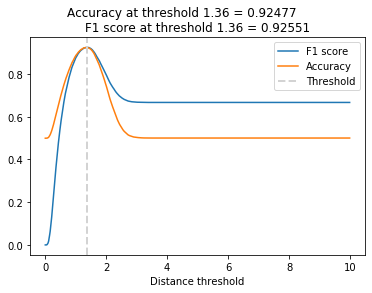

In [9]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, auc
from matplotlib import pyplot as plt
import seaborn as sns
# from sklearn.metrics import f1_score

distances_list = np.array(distances_list)
identical_list = np.array(identical_list)

thresholds = np.arange(0.00, 10.0, 0.01)
# thresholds = np.arange(0.05, 3.0, 0.01)

f1_scores = [f1_score(identical_list, distances_list < t) for t in thresholds]
acc_scores = [accuracy_score(identical_list, distances_list < t) for t in thresholds]

opt_idx = np.argmax(f1_scores) # Threshold at maximal F1 score
# opt_idx = np.argmax(acc_scores) # Threshold at maximal Accuracy score

opt_tau = thresholds[opt_idx]
opt_acc = accuracy_score(identical_list, distances_list < opt_tau) # Accuracy at maximal F1 score

# Plot F1 score and Accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');

# plt.plot(thresholds, acc_scores, color = 'darkorange', label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=2, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.5f}\
        \nF1 score at threshold {opt_tau:.2f} = {np.max(f1_scores):.5f}');
plt.xlabel('Distance threshold')
plt.legend();

# Distribution of Distances Visualization

f1_scores: 0.92551

Threshold: 1.36

Accuracy: 0.92477

True Positive Rate: 0.93383
False Negative Rate: 0.06617

False Positive Rate: 0.08430
True Negative Rate: 0.91570


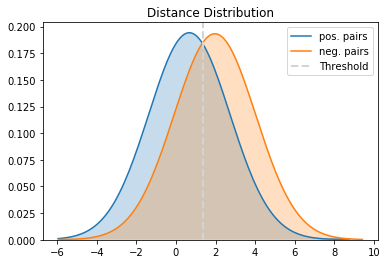

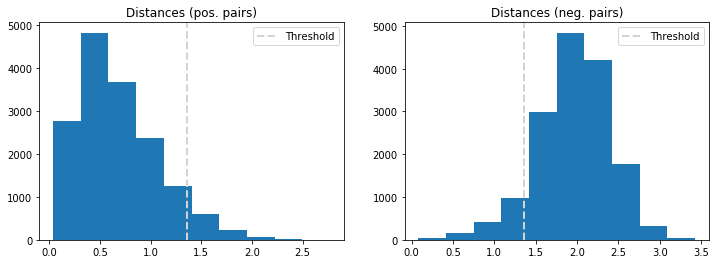

In [10]:
dist_pos = distances_list[identical_list == 1]
dist_neg = distances_list[identical_list == 0]

tpr_list = np.zeros(thresholds.shape)
fpr_list = np.zeros(thresholds.shape)

fnr_list = np.zeros(thresholds.shape)
tnr_list = np.zeros(thresholds.shape)

for i in range(0, len(thresholds)):
    tpr = dist_pos[dist_pos < thresholds[i]]
    tpr = len(tpr)/len(dist_pos)
    tpr_list[i] = tpr
    fnr_list[i] = 1.0 - tpr
    
    fpr = dist_neg[dist_neg < thresholds[i]]
    fpr = (len(fpr)/len(dist_neg))
    fpr_list[i] = fpr
    tnr_list[i] = 1.0 - fpr

print("f1_scores: %.5f\n" % np.max(f1_scores))

print("Threshold: %.2f\n" % opt_tau)
print("Accuracy: %.5f\n" % opt_acc)

print("True Positive Rate: %.5f" % tpr_list[opt_idx])
print("False Negative Rate: %.5f\n" % fnr_list[opt_idx])

print("False Positive Rate: %.5f" % fpr_list[opt_idx])
print("True Negative Rate: %.5f" % tnr_list[opt_idx])


# Kernel Density Estimate Plot
sns.kdeplot(dist_pos, shade=True, bw=2, label="pos. pairs")
sns.kdeplot(dist_neg, shade=True, bw=2, label="neg. pairs")
plt.axvline(x=opt_tau, linestyle='--', lw=2, c='lightgrey', label='Threshold')
plt.title('Distance Distribution')
plt.legend()
plt.show()

# visualizeation of distance distribution
plt.figure(figsize=(12,4))
plt.subplot(121)

plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=2, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=2, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# ROC Curve

AUC: 0.9733664737911462



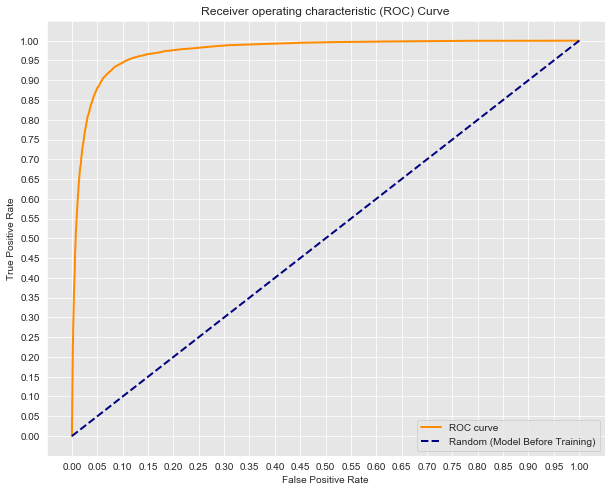

In [11]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}\n'.format(auc(fpr_list, tpr_list)))
plt.figure(figsize=(10, 8))
plt.plot(fpr_list, tpr_list, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (Model Before Training)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()